# OpenGhostbuster

## Baselines

In [181]:
import gc
import json
from pathlib import Path

import numpy as np
import torch
from tqdm.auto import tqdm
import pandas as pd

In [182]:
preds_path = Path("/storage/projects/stoeckel/GhostWriter/predictions")

## Evaluation

In [183]:
from luminar.utils.evaluation import run_evaluation
from luminar.baselines.binoculars import GLOBAL_BINOCULARS_THRESHOLD


results = []
for preds_model_path in preds_path.iterdir():
    for corpus_path in preds_model_path.glob("*.csv"):
        corpus = corpus_path.stem

        if preds_model_path.stem.startswith("binoculars"):
            threshold = GLOBAL_BINOCULARS_THRESHOLD
            sigmoid = False
            less_than = True
        elif preds_model_path.stem.startswith(
            "radar"
        ) or preds_model_path.stem.startswith("e5_lora"):
            threshold = 0.5
            sigmoid = False
            less_than = False
        elif preds_model_path.stem.startswith("fast_detectgpt"):
            threshold = 0.5
            sigmoid = True
            less_than = False
        elif preds_model_path.stem.startswith("detectllm"):
            threshold = 0.5
            sigmoid = True
            less_than = False
        else:
            raise RuntimeError(f"Unknown model {preds_model_path.stem}")

        df = pd.read_csv(corpus_path, index_col=0)
        df = df.dropna(subset=["y_score", "label"])

        # binarize labels
        df = df[df["label"] < 2]
        # df["label"] = (df["label"] > 0).astype(int)

        agents = set(df["agent"].unique())
        if "human" in agents:
            agents.remove("human")

        if not agents:
            agents = ("human",)

        for agent in agents:
            df_agent = df[(df["agent"] == "human") | (df["agent"] == agent)]

            labels = df_agent["label"]
            y_scores = df_agent["y_score"]
            y_preds = df_agent["y_pred"] if "y_pred" in df_agent.columns else None

            results.append(
                {
                    "model": preds_model_path.stem,
                    "corpus": corpus,
                    "agent": agent,
                    "domain": "all",
                }
                | run_evaluation(
                    np.array(labels),
                    np.array(y_scores),
                    threshold=threshold,
                    sigmoid=sigmoid,
                    less_than=less_than,
                    y_preds=np.array(y_preds) if y_preds is not None else None,
                )
            )

        for domain in df["domain"].unique():
            df_domain = df[(df["domain"] == domain)]

            labels = df_domain["label"]
            y_scores = df_domain["y_score"]
            y_preds = df_domain["y_pred"] if "y_pred" in df_domain.columns else None

            results.append(
                {
                    "model": preds_model_path.stem,
                    "corpus": corpus,
                    "agent": "all",
                    "domain": domain,
                }
                | run_evaluation(
                    np.array(labels),
                    np.array(y_scores),
                    threshold=threshold,
                    sigmoid=sigmoid,
                    less_than=less_than,
                    y_preds=np.array(y_preds) if y_preds is not None else None,
                )
            )

/nvme/projects/PrismAI/PrismAI/.venv/lib/python3.12/site-packages/sklearn/metrics/_classification.py:1731: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", result.shape[0])
/nvme/projects/PrismAI/PrismAI/.venv/lib/python3.12/site-packages/sklearn/metrics/_classification.py:1731: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", result.shape[0])
/nvme/projects/PrismAI/PrismAI/.venv/lib/python3.12/site-packages/sklearn/metrics/_classification.py:1731: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{me

In [184]:
df = pd.DataFrame.from_records(results)
df

,model,corpus,agent,domain,n_samples,f1_score,precision,recall,accuracy,roc_auc,...,roc_auc_fpr,fpr_fpr,tpr_fpr,tnr_fpr,fnr_fpr,f1_human_fpr,f1_ai_fpr,threshold_fpr,n_samples_human,n_samples_ai
0,fast_detectgpt-gpt-neo-2,test,deepseek-r1:32b,all,30124,0.050696,0.985507,0.036615,0.036615,0.753527,...,0.753527,0.050406,0.205521,0.949594,0.794479,0.969822,0.070712,0.999430,29798,326
1,fast_detectgpt-gpt-neo-2,test,gpt-4o-mini,all,48425,0.246891,0.709402,0.399153,0.399153,0.885700,...,0.885700,0.050406,0.604016,0.949594,0.395984,0.864396,0.717081,0.999430,29798,18627
2,fast_detectgpt-gpt-neo-2,test,deepseek-r1:1.5b,all,30298,0.050575,0.918965,0.040432,0.040432,0.245085,...,0.245085,0.050406,0.000000,0.949594,1.000000,0.965833,0.000000,0.999430,29798,500
3,fast_detectgpt-gpt-neo-2,test,gpt-4-turbo,all,29897,0.050871,0.996700,0.029401,0.029401,0.853570,...,0.853570,0.050406,0.282828,0.949594,0.717172,0.972956,0.034377,0.999430,29798,99
4,fast_detectgpt-gpt-neo-2,test,gemma2:9b,all,51443,0.278600,0.592014,0.429854,0.429854,0.798257,...,0.798257,0.050406,0.304597,0.949594,0.695403,0.773686,0.443376,0.999430,29798,21645
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
131,detectllm_llr-falcon-7b,test,all,bundestag,8738,0.418155,0.329002,0.573587,0.573587,0.914901,...,0.914901,0.049651,0.756185,0.950349,0.243815,0.834256,0.843441,0.883393,3726,5012
132,detectllm_llr-falcon-7b,test,all,euro_court_cases,4640,0.457108,0.367017,0.605819,0.605819,0.691270,...,0.691270,0.049754,0.264674,0.950246,0.735326,0.616968,0.408118,0.908579,1829,2811
133,detectllm_llr-falcon-7b,test,all,cnn_news,9258,0.440839,0.351010,0.592461,0.592461,0.882894,...,0.882894,0.050093,0.662534,0.949907,0.337466,0.778454,0.780834,0.903587,3773,5485
134,detectllm_llr-falcon-7b,test,all,arxiv_papers,4741,0.520508,0.431140,0.656613,0.656613,0.923294,...,0.923294,0.049754,0.812078,0.950246,0.187922,0.822872,0.883607,0.895791,1628,3113


In [185]:
# %%script echo skipping
df.to_csv(preds_path / "GhostWriter_test-likelihood_baselines.csv", index=False)
df.to_csv(
    Path("/resources/public/stoeckel/PrismAI")
    / "GhostWriter_test-likelihood_baselines.csv",
    index=False,
)

In [186]:
def postprocess_df_domain(_df: pd.DataFrame) -> pd.DataFrame:
    _df = (
        _df.set_index("domain")
        .sort_index()
        .rename(
            index={
                "arxiv_papers": "arXiv",
                "blog_authorship_corpus": "Blogs",
                "bundestag": "Bundestag",
                "cnn_news": "CNN",
                "euro_court_cases": "ECHR",
                "gutenberg": "Gutenberg",
                "house_of_commons": "HoC",
                "spiegel_articles": "Spiegel",
                "student_essays": "Essays",
            },
        )
        .drop(columns=["model"])
    )
    _df.loc["Overall"] = _df.mean(numeric_only=True)
    return _df


def postprocess_df_agent(_df: pd.DataFrame) -> pd.DataFrame:
    _df = (
        _df.set_index("agent")
        .sort_index()
        .rename(
            index={
                "arxiv_papers": "arXiv",
                "blog_authorship_corpus": "Blogs",
                "bundestag": "Bundestag",
                "cnn_news": "CNN",
                "euro_court_cases": "ECHR",
                "gutenberg": "Gutenberg",
                "house_of_commons": "HoC",
                "spiegel_articles": "Spiegel",
                "student_essays": "Essays",
            },
        )
        .drop(columns=["model"])
    )
    _df.loc["Overall"] = _df.mean(numeric_only=True)
    return _df

In [187]:
df_subset_agent = df[(df["agent"] != "all")].copy()
df_subset_domain = df[(df["domain"] != "all")].copy()


def get_figure_df_agent(model: str, variant: str = "") -> pd.DataFrame:
    _df = df_subset_agent[df_subset_agent["model"] == model].copy()
    _df["f1_macro"] = (_df[f"f1_human{variant}"] + _df[f"f1_ai{variant}"]) / 2
    return _df[
        [
            "model",
            "agent",
            "f1_macro",
            f"roc_auc{variant}",
            f"tpr{variant}",
            f"fpr{variant}",
        ]
    ]


def get_figure_df_domain(model: str, variant: str = "") -> pd.DataFrame:
    _df = df_subset_domain[df_subset_domain["model"] == model].copy()
    _df["f1_macro"] = (_df[f"f1_human{variant}"] + _df[f"f1_ai{variant}"]) / 2
    return _df[
        [
            "model",
            "domain",
            "f1_macro",
            f"roc_auc{variant}",
            f"tpr{variant}",
            f"fpr{variant}",
        ]
    ]


### By Domain

In [188]:
df_fdg_j6B_neo27 = get_figure_df_domain("fast_detectgpt-gpt-j-6B_gpt-neo-2", "_mean")
df_fdg_falcon_7b = get_figure_df_domain("fast_detectgpt-falcon-7b", "_mean")
df_fdg_falcon_7b_instruct = get_figure_df_domain(
    "fast_detectgpt-falcon-7b_falcon-7b-instruct", "_mean"
)
df_dllm_falcon_7b = get_figure_df_domain("detectllm_llr-falcon-7b", "_mean")
df_binoculars = get_figure_df_domain("binoculars_falcon-7b", "_mean")

dfs_likelihood = [
    postprocess_df_domain(_df.copy())
    for _df in (
        df_dllm_falcon_7b,
        df_fdg_falcon_7b_instruct,
        df_binoculars,
    )
]
df_figure_likelihood = pd.concat(dfs_likelihood, axis=1)
print(df_figure_likelihood.to_latex(float_format="%.3f"))

\begin{tabular}{lrrrrrrrrrrrr}
\toprule
 & f1_macro & roc_auc_mean & tpr_mean & fpr_mean & f1_macro & roc_auc_mean & tpr_mean & fpr_mean & f1_macro & roc_auc_mean & tpr_mean & fpr_mean \\
domain &  &  &  &  &  &  &  &  &  &  &  &  \\
\midrule
arXiv & 0.865 & 0.923 & 0.853 & 0.088 & 0.934 & 0.990 & 0.984 & 0.136 & 0.947 & 0.991 & 0.925 & 0.001 \\
Blogs & 0.605 & 0.668 & 0.632 & 0.421 & 0.660 & 0.720 & 0.649 & 0.325 & 0.664 & 0.717 & 0.668 & 0.338 \\
Bundestag & 0.854 & 0.915 & 0.805 & 0.078 & 0.872 & 0.949 & 0.911 & 0.172 & 0.883 & 0.947 & 0.839 & 0.057 \\
CNN & 0.818 & 0.883 & 0.801 & 0.151 & 0.893 & 0.968 & 0.964 & 0.195 & 0.960 & 0.970 & 0.937 & 0.005 \\
ECHR & 0.646 & 0.691 & 0.672 & 0.371 & 0.820 & 0.935 & 0.923 & 0.301 & 0.886 & 0.945 & 0.852 & 0.056 \\
Gutenberg & 0.778 & 0.899 & 0.836 & 0.176 & 0.919 & 0.988 & 0.981 & 0.174 & 0.916 & 0.991 & 0.928 & 0.013 \\
HoC & 0.771 & 0.824 & 0.778 & 0.222 & 0.897 & 0.964 & 0.942 & 0.156 & 0.937 & 0.964 & 0.908 & 0.013 \\
Spiegel & 0.803 & 0

In [189]:
df_radar = get_figure_df_domain("radar")
df_e5_lora = get_figure_df_domain("e5_lora")

df_figure_supervised = pd.concat(
    [
        postprocess_df_domain(df_radar),
        postprocess_df_domain(df_e5_lora),
    ],
    axis=1,
)
print(df_figure_supervised.to_latex(float_format="%.3f", na_rep=""))

\begin{tabular}{lrrrrrrrr}
\toprule
 & f1_macro & roc_auc & tpr & fpr & f1_macro & roc_auc & tpr & fpr \\
domain &  &  &  &  &  &  &  &  \\
\midrule
arXiv & 0.405 & 0.839 & 0.150 & 0.004 & 0.570 & 0.965 & 0.994 & 0.809 \\
Blogs & 0.508 & 0.499 & 0.588 & 0.571 & 0.659 & 0.803 & 0.918 & 0.578 \\
Bundestag & 0.334 & 0.395 & 0.044 & 0.052 & 0.381 & 0.339 & 0.724 & 0.886 \\
CNN & 0.606 & 0.942 & 0.370 & 0.019 & 0.647 & 0.968 & 0.997 & 0.679 \\
ECHR & 0.620 & 0.661 & 0.574 & 0.306 & 0.406 & 0.877 & 0.993 & 0.971 \\
Gutenberg & 0.357 & 0.753 & 0.215 & 0.084 & 0.880 & 0.969 & 0.937 & 0.149 \\
HoC & 0.624 & 0.773 & 0.504 & 0.188 & 0.838 & 0.990 & 0.999 & 0.360 \\
Spiegel & 0.294 & 0.670 & 0.022 & 0.007 & 0.511 & 0.632 & 0.346 & 0.200 \\
Essays & 0.602 & 0.754 & 0.405 & 0.123 & 0.540 & 0.846 & 0.996 & 0.807 \\
Overall & 0.483 & 0.698 & 0.319 & 0.150 & 0.604 & 0.821 & 0.878 & 0.604 \\
\bottomrule
\end{tabular}



### By Agent

In [190]:
df_fdg_j6B_neo27 = get_figure_df_agent("fast_detectgpt-gpt-j-6B_gpt-neo-2", "_mean")
df_fdg_falcon_7b = get_figure_df_agent("fast_detectgpt-falcon-7b", "_mean")
df_fdg_falcon_7b_instruct = get_figure_df_agent(
    "fast_detectgpt-falcon-7b_falcon-7b-instruct", "_mean"
)
df_dllm_falcon_7b = get_figure_df_agent("detectllm_llr-falcon-7b", "_mean")
df_binoculars = get_figure_df_agent("binoculars_falcon-7b", "_mean")
dfs_likelihood = [
    postprocess_df_agent(_df.copy())
    for _df in (
        df_dllm_falcon_7b,
        df_fdg_falcon_7b_instruct,
        df_binoculars,
    )
]
df_figure_likelihood = pd.concat(dfs_likelihood, axis=1)
print(df_figure_likelihood.to_latex(float_format="%.3f"))

\begin{tabular}{lrrrrrrrrrrrr}
\toprule
 & f1_macro & roc_auc_mean & tpr_mean & fpr_mean & f1_macro & roc_auc_mean & tpr_mean & fpr_mean & f1_macro & roc_auc_mean & tpr_mean & fpr_mean \\
agent &  &  &  &  &  &  &  &  &  &  &  &  \\
\midrule
deepseek-r1:1.5b & 0.260 & 0.268 & 0.340 & 0.660 & 0.445 & 0.815 & 0.782 & 0.313 & 0.486 & 0.810 & 0.746 & 0.222 \\
deepseek-r1:32b & 0.402 & 0.722 & 0.656 & 0.374 & 0.474 & 0.922 & 0.890 & 0.228 & 0.590 & 0.915 & 0.798 & 0.062 \\
gemma2:9b & 0.667 & 0.754 & 0.702 & 0.354 & 0.833 & 0.937 & 0.908 & 0.220 & 0.882 & 0.933 & 0.820 & 0.065 \\
gpt-4-turbo & 0.412 & 0.814 & 0.768 & 0.321 & 0.465 & 0.986 & 0.980 & 0.187 & 0.548 & 0.982 & 0.919 & 0.045 \\
gpt-4o-mini & 0.810 & 0.900 & 0.833 & 0.195 & 0.880 & 0.985 & 0.974 & 0.175 & 0.963 & 0.986 & 0.926 & 0.010 \\
nemotron & 0.294 & 0.414 & 0.530 & 0.610 & 0.441 & 0.788 & 0.748 & 0.326 & 0.506 & 0.799 & 0.725 & 0.193 \\
o3-mini & 0.327 & 0.499 & 0.548 & 0.531 & 0.428 & 0.819 & 0.780 & 0.312 & 0.450 & 0.803 

In [191]:
df_stats = df_subset_agent.drop(
    columns=[
        "corpus",
        "n_samples",
        "f1_score",
        "precision",
        "recall",
        "accuracy",
        "roc_auc",
        "fpr",
        "tpr",
        "tnr",
        "fnr",
        "f1_human",
        "f1_ai",
        "f1_score_mean",
        "precision_mean",
        "recall_mean",
        "accuracy_mean",
        "roc_auc_mean",
        "fpr_mean",
        "tpr_mean",
        "tnr_mean",
        "fnr_mean",
        "f1_human_mean",
        "f1_ai_mean",
        "f1_score_fpr",
        "precision_fpr",
        "recall_fpr",
        "accuracy_fpr",
        "roc_auc_fpr",
        "fpr_fpr",
        "tpr_fpr",
        "tnr_fpr",
        "fnr_fpr",
        "f1_human_fpr",
        "f1_ai_fpr",
        "threshold_fpr",
        "n_samples_human",
        "n_samples_ai",
        "agent",
    ]
)
df_stats = df_stats[
    (df_stats["model"] == "binoculars_falcon-7b")
    | (df_stats["model"] == "fast_detectgpt-falcon-7b_falcon-7b-instruct")
]
df_stats.groupby(["model"]).agg(
    threshold_mean_avg=("threshold_mean", "mean"),
    threshold_mean_std=("threshold_mean", "std"),
    threshold_mean_min=("threshold_mean", "min"),
    threshold_mean_max=("threshold_mean", "max"),
).reset_index()

,model,threshold_mean_avg,threshold_mean_std,threshold_mean_min,threshold_mean_max
0,binoculars_falcon-7b,0.947292,0.044042,0.883768,1.032621
1,fast_detectgpt-falcon-7b_falcon-7b-instruct,0.656870,0.116094,0.387852,0.748362


In [192]:
binoculars_scores = pd.read_csv(
    "/storage/projects/stoeckel/GhostWriter/predictions/binoculars_falcon-7b/test.csv"
)
binoculars_scores

,Unnamed: 0,id,domain,date,source,lang,label,agent,type,length,y_score,y_pred
0,0,ebd1552b-7481-49a9-8100-a28a412cbdc8,arxiv_papers,2025,709e0f5a-765f-47f4-8d5b-8c43e1ac273f,en-EN,1,gemma2:9b,fulltext,0,NaN,0
1,1,8f7d5ada-666f-44c7-b186-4c062b654854,euro_court_cases,2025,190bf92c-ecd5-4108-9913-d67213e92c6e,en-EN,1,gemma2:9b,fulltext,0,NaN,0
2,2,c1d37128-23bd-4e8c-a6cd-bf909ed50056,euro_court_cases,2025,af0850c2-bfb6-4163-bb64-77f31832e6c3,en-EN,1,gemma2:9b,fulltext,0,NaN,0
3,3,5a15bea5-a0f8-4bfb-b82f-65fdba567a67,house_of_commons,2025,4b87cdcf-cc74-49eb-bfb0-a553f28e18f3,en-EN,1,gemma2:9b,fulltext,0,NaN,0
4,4,913d548a-c660-414d-90e8-2822817cc146,gutenberg,2025,c17e2a22-7052-432f-9a23-034071f5155f__[0:6],en-EN,2,gemma2:9b,chunk,1,NaN,0
...,...,...,...,...,...,...,...,...,...,...,...,...
109291,109291,116bf255-9bf8-4f81-80b9-eb25f57e2a0b,bundestag,2020-01-29T00:00:00,https://bundestag-mine.de/api/DashboardControl...,de-DE,0,human,fulltext,512,0.989744,0
109292,109292,a4fc42fb-cb23-4107-b975-1d004692f2f6,student_essays,2025,67ca891c-ae24-49d4-8a22-1df752ddc14c__[0:987],en-EN,2,gpt-4o-mini,chunk,512,0.931973,0
109293,109293,69ef1b80-c367-48ae-b3ba-ad03f7675e9b,student_essays,2025,da9a35cd-4956-4b8b-b1d1-8877aaf97641,en-EN,1,gemma2:9b,fulltext,512,0.851190,1
109294,109294,1d39ca7f-7fad-4282-8d34-ea56761f8b39,bundestag,2025,4f636f77-48f6-449e-9856-b02febd8f307__[0:1939],de-DE,2,gemma2:9b,chunk,512,0.931035,0


In [193]:
binoculars_scores.groupby("label").agg(
    y_score_min=("y_score", "min"),
    y_score_max=("y_score", "max"),
    y_score_mean=("y_score", "mean"),
    y_score_std=("y_score", "std"),
)

,y_score_min,y_score_max,y_score_mean,y_score_std
label,,,,
0,0.335681,2.212766,0.997357,0.062132
1,0.329327,1.923664,0.830224,0.104581
2,0.550847,1.389163,0.964090,0.062352


<Axes: xlabel='y_score', ylabel='Count'>

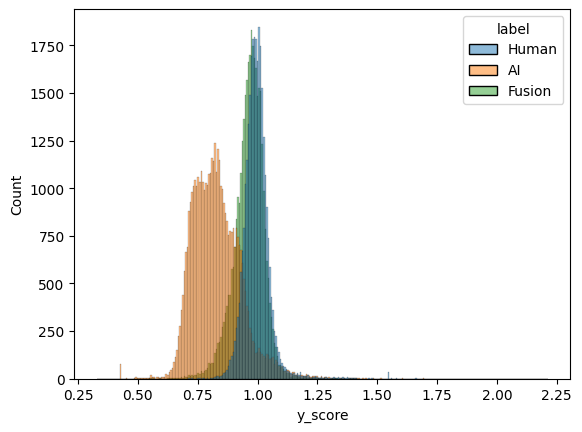

In [194]:
import seaborn as sns


plot_df = binoculars_scores.dropna()[["y_score", "label"]].replace(
    {"label": {0: "Human", 1: "AI", 2: "Fusion"}}
)
sns.histplot(plot_df, x="y_score", hue="label")

In [212]:
import seaborn.objects as so
from seaborn import axes_style

import matplotlib.pyplot as plt



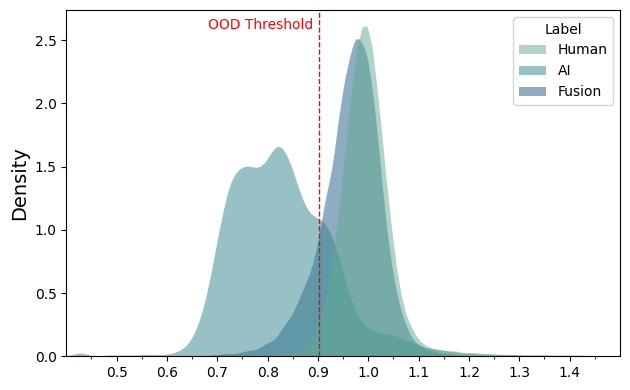

In [303]:
fig = plt.figure(figsize=(6.4, 4))
ax = plt.gca()

plot = sns.kdeplot(
    data=plot_df,
    x="y_score",
    hue="label",
    fill=True,
    common_norm=True,
    legend=True,
    palette="crest",
    alpha=0.5,
    linewidth=0,
    ax=ax,
)

plot.set_xlim(0.4, 1.5)
plot.set_xticks(np.arange(0.5, 1.5, 0.1), minor=False)
plot.set_xticks(np.arange(0.45, 1.5, 0.05), minor=True)
plot.set_ylabel("Density", fontdict={"size": 14})
plot.set_xlabel(
    None,
    # "Binoculars Score", fontdict={"size": 14},
)

legend = ax.get_legend()
legend.set_title("Label")
# sns.move_legend(ax, "upper right", bbox_to_anchor=(1, 1))

ymin, ymax = plot.get_ylim()
ax.vlines(
    [GLOBAL_BINOCULARS_THRESHOLD],
    ymin=ymin,
    ymax=ymax,
    colors="red",
    linestyles="--",
    linewidth=1,
)
ax.annotate(
    "OOD Threshold",
    (GLOBAL_BINOCULARS_THRESHOLD - 0.22, ymax - 0.15),
    color="red",
)

ax.set_ylim(ymin, ymax)
plt.tight_layout()
plt.savefig("../figures/binoculars-score_distribution-all_domains_and_agents.pgf")
plt.show()

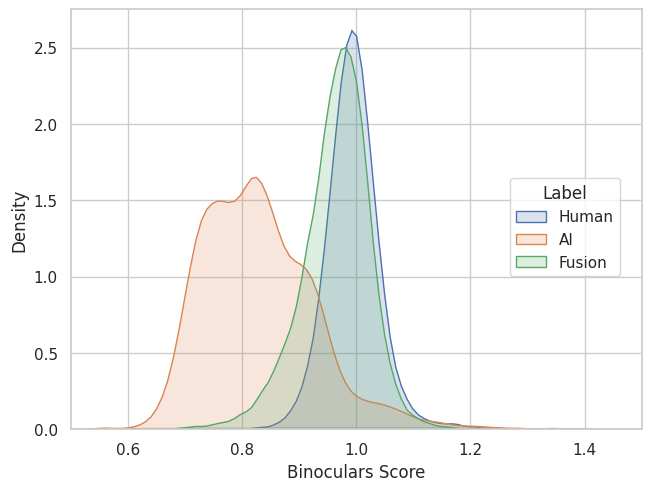

In [240]:

o = (
    so.Plot(plot_df, x="y_score", color="label")
    .add(
        so.Area(),
        so.KDE(),
    )
    .limit(x=(0.5, 1.5))
    .label(
        x="Binoculars Score",
        y="Density",
        color="Label",
        # title="Distribution of Binoculars Scores by Label",
    )
    .theme(
        axes_style("whitegrid")
        # | {"axes.edgecolor": "slategrey", "grid.color": "slategrey"}
    )
    .layout(engine="constrained")
)
o.save
o.show()